In [1]:
import mne, os
import basic.arrange_data as arrange
import signal_processing.erp_analysis as erpan
import numpy as np
from cmath import nan
import matplotlib.pyplot as plt
import pandas as pd

mne.set_log_level('error')

In [8]:
exp_folder = r"Auditory Oddball/10 weeks" # in case you want to just type the dir here
#exp_folder = input('Experiment folder (e.g., Eyes Open\Baseline):')

raw_folder = r"Data/Raw/OKTOS/"
clean_folder = r"Data/Clean/OKTOS"
# dir_inprogress = os.path.join(raw_folder,exp_folder)
# export_dir = os.path.join(clean_folder,exp_folder)

results_foldername = r"Results/OKTOS"
exp_condition = r"AO_07"

Files in Data/Clean/OKTOS/Auditory Oddball/10 weeks read in: 27


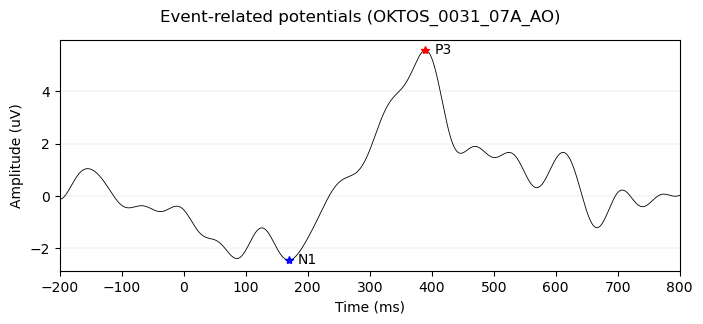

Changing time window parameters for OKTOS_0031_07A_AO
Changing N1 with new time window: [80, 120, -1]


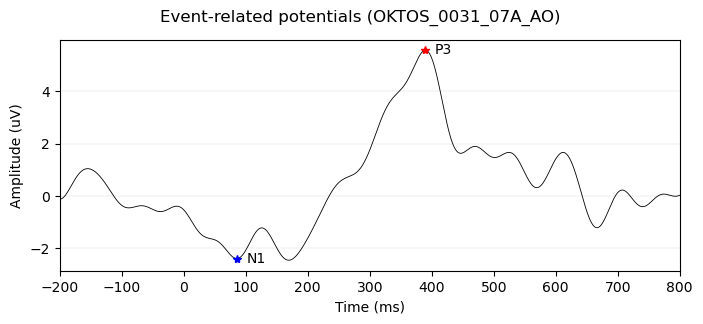

Changing time window parameters for OKTOS_0031_07A_AO
Changing P2 with new time window: [100, 170, 1]


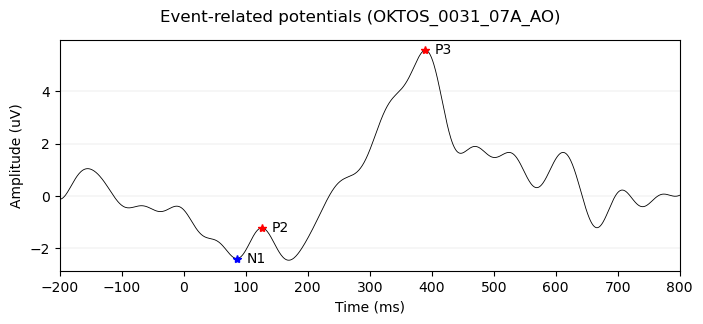

Changing time window parameters for OKTOS_0031_07A_AO
Changing N2 with new time window: [150, 200, -1]


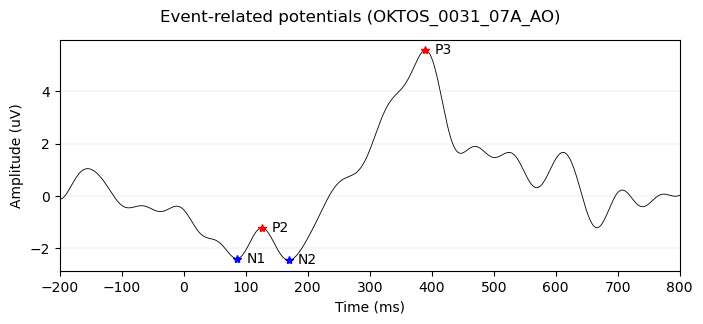

ERPs have been found and added to the dataframe for OKTOS_0031_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.9375,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867


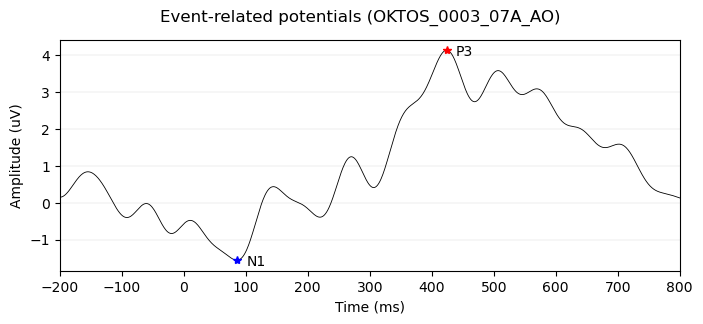

Changing time window parameters for OKTOS_0003_07A_AO
Changing N2 with new time window: [150, 300, -1]


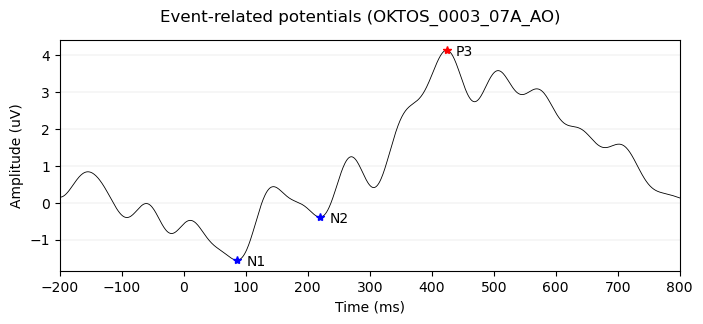

Changing time window parameters for OKTOS_0003_07A_AO
Changing P2 with new time window: [100, 200, 1]


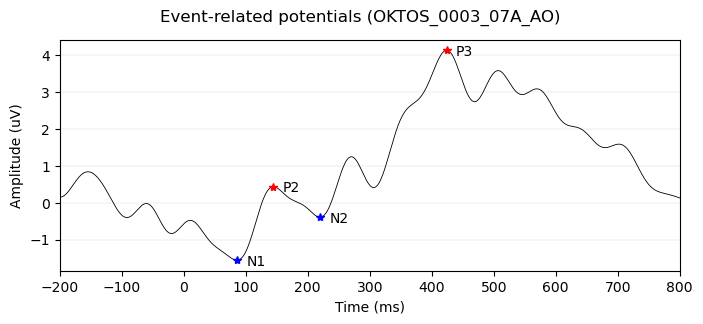

ERPs have been found and added to the dataframe for OKTOS_0003_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.9375,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.9375,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873


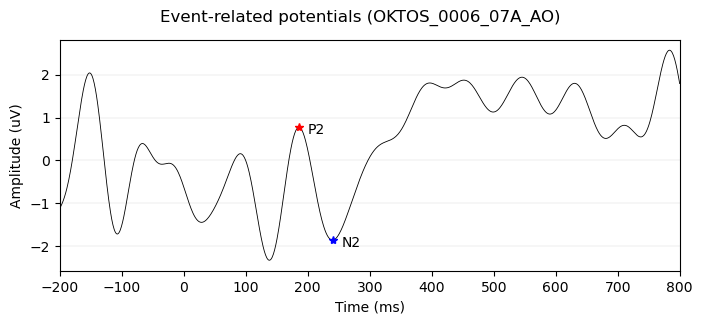

Changing time window parameters for OKTOS_0006_07A_AO
Changing N1 with new time window: [100, 150, -1]


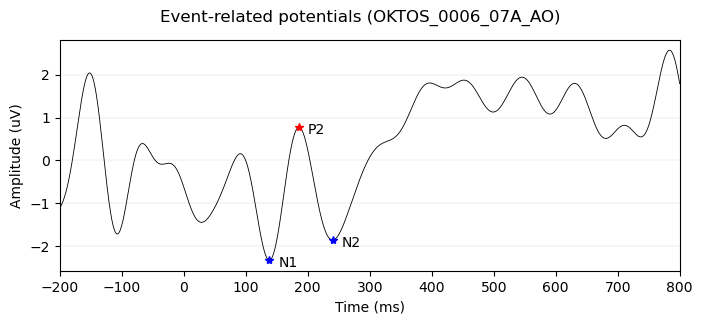

Changing time window parameters for OKTOS_0006_07A_AO
Changing P3 with new time window: [300, 500, 1]


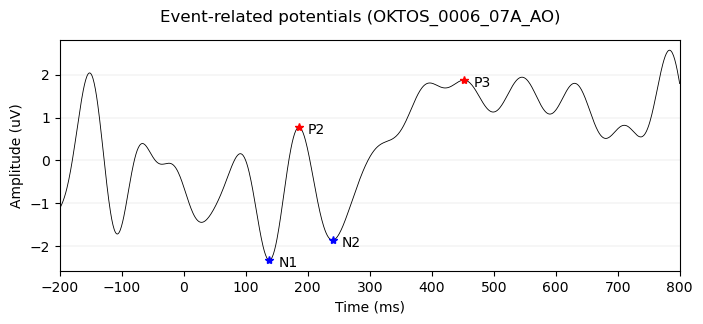

ERPs have been found and added to the dataframe for OKTOS_0006_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475


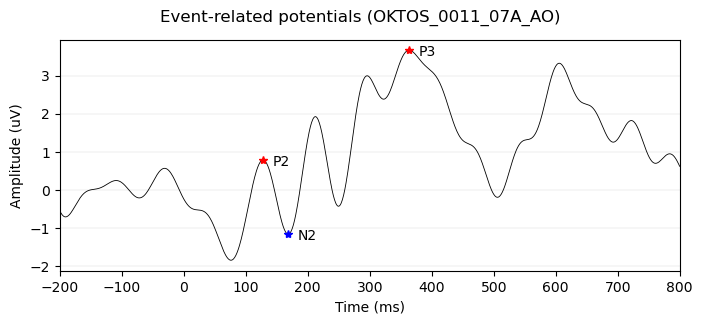

Changing time window parameters for OKTOS_0011_07A_AO
Changing N1 with new time window: [50, 100, -1]


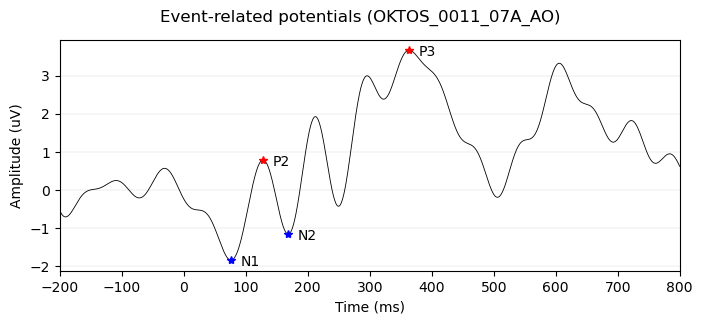

ERPs have been found and added to the dataframe for OKTOS_0011_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356


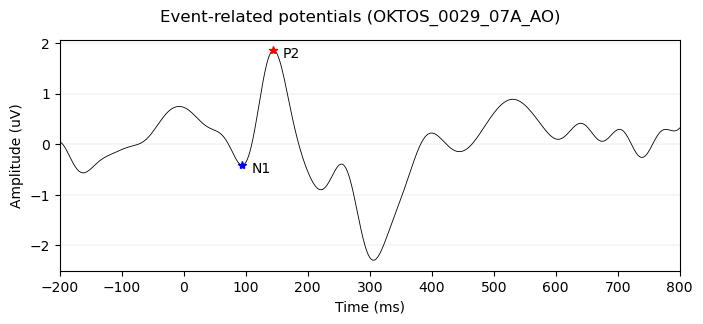

Changing time window parameters for OKTOS_0029_07A_AO
Changing N2 with new time window: [200, 350, -1]


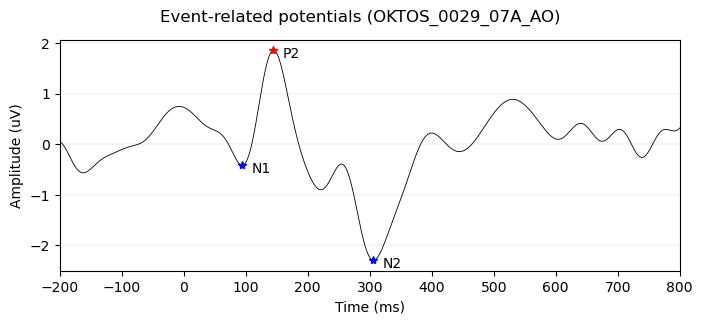

Changing time window parameters for OKTOS_0029_07A_AO
Changing P3 with new time window: [300, 600, 1]


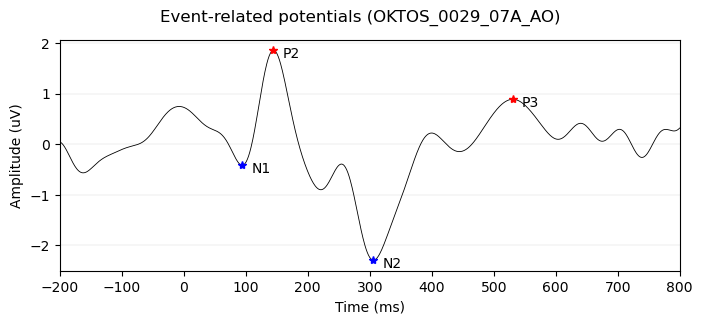

ERPs have been found and added to the dataframe for OKTOS_0029_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047


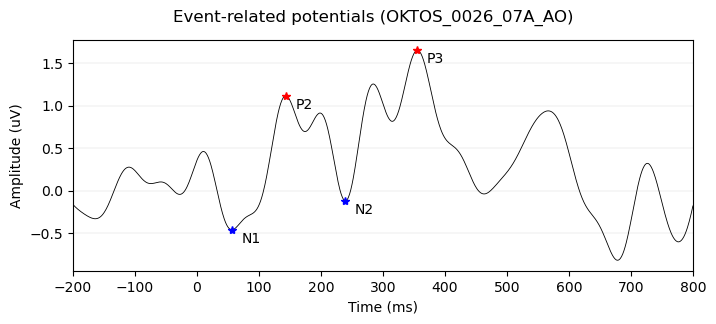

ERPs have been found and added to the dataframe for OKTOS_0026_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166


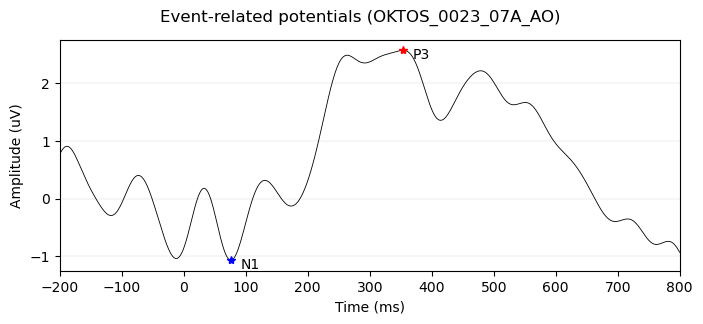

Changing time window parameters for OKTOS_0023_07A_AO
Changing P2 with new time window: [100, 200, 1]


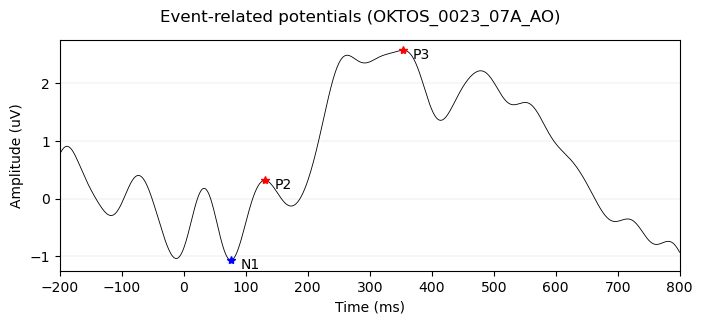

Changing time window parameters for OKTOS_0023_07A_AO
Changing N2 with new time window: [150, 200, -1]


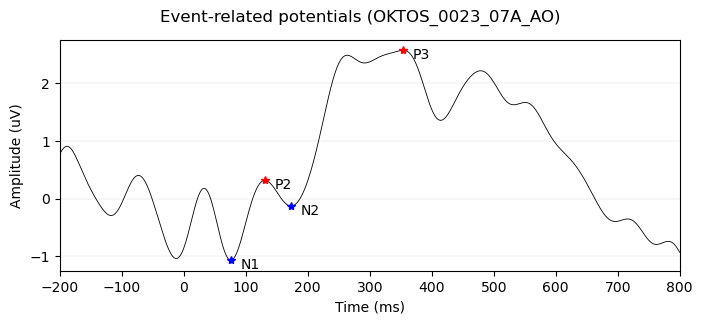

ERPs have been found and added to the dataframe for OKTOS_0023_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550


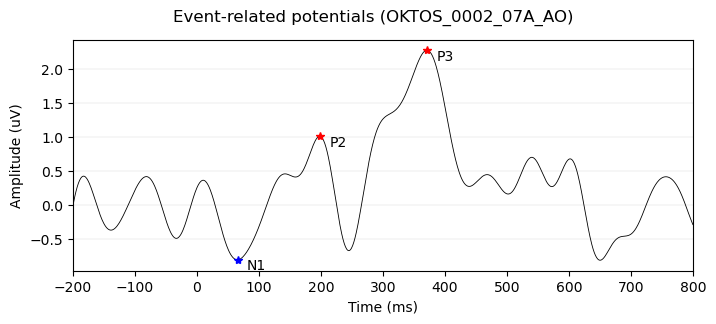

Changing time window parameters for OKTOS_0002_07A_AO
Changing N2 with new time window: [200, 300, -1]


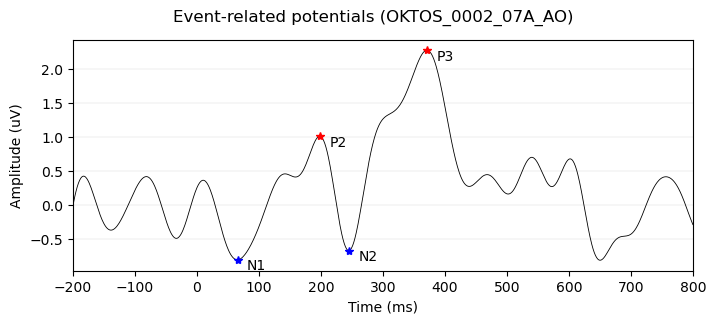

ERPs have been found and added to the dataframe for OKTOS_0002_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144


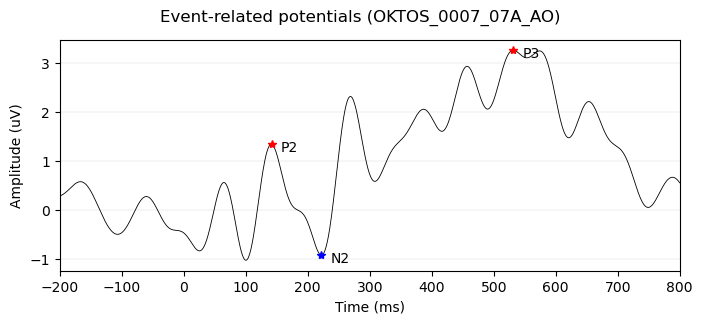

Changing time window parameters for OKTOS_0007_07A_AO
Changing N1 with new time window: [80, 120, -1]


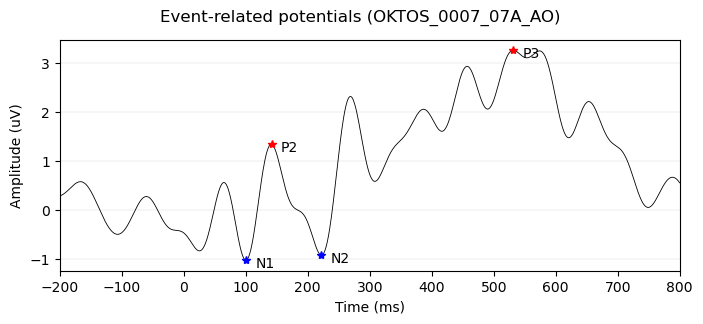

ERPs have been found and added to the dataframe for OKTOS_0007_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044


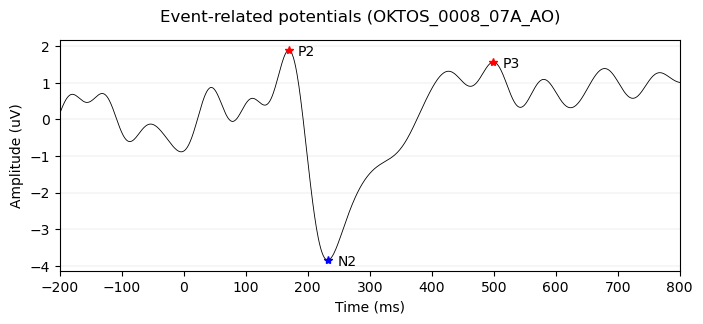

Changing time window parameters for OKTOS_0008_07A_AO
Changing N1 with new time window: [50, 120, -1]


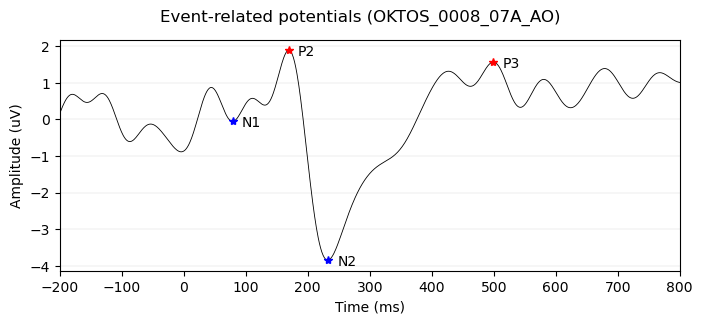

ERPs have been found and added to the dataframe for OKTOS_0008_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


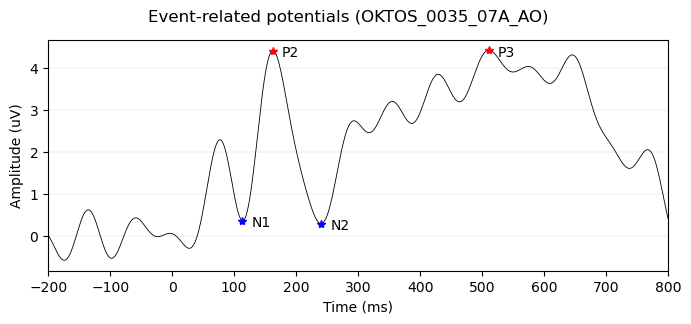

ERPs have been found and added to the dataframe for OKTOS_0035_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


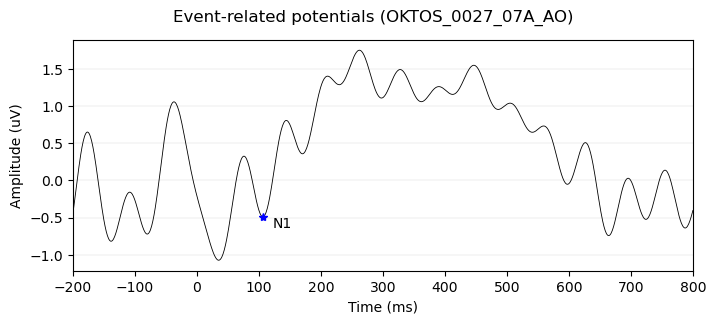

Changing time window parameters for OKTOS_0027_07A_AO
Changing P2 with new time window: [100, 150, 1]


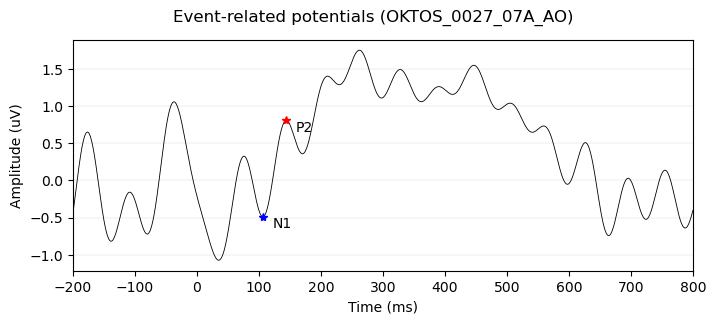

Changing time window parameters for OKTOS_0027_07A_AO
Changing N2 with new time window: [140, 200, -1]


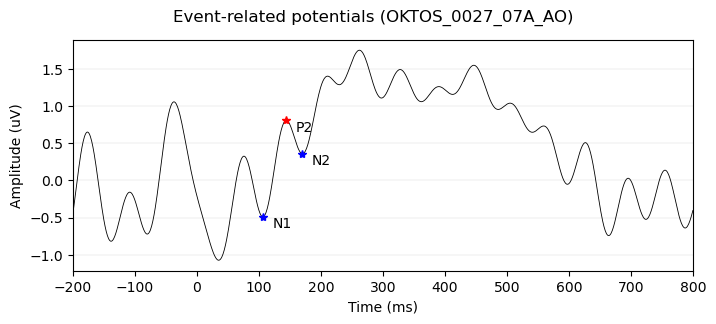

Changing time window parameters for OKTOS_0027_07A_AO
Changing P3 with new time window: [200, 300, 1]


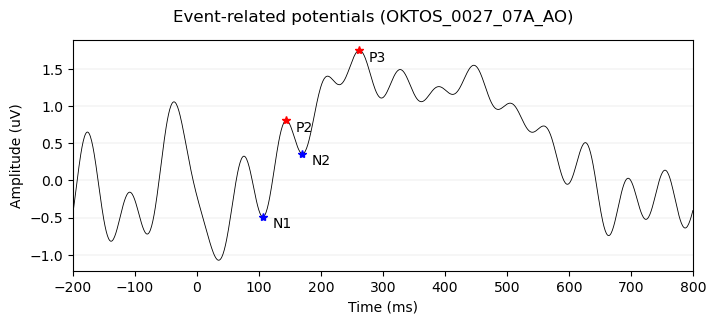

ERPs have been found and added to the dataframe for OKTOS_0027_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


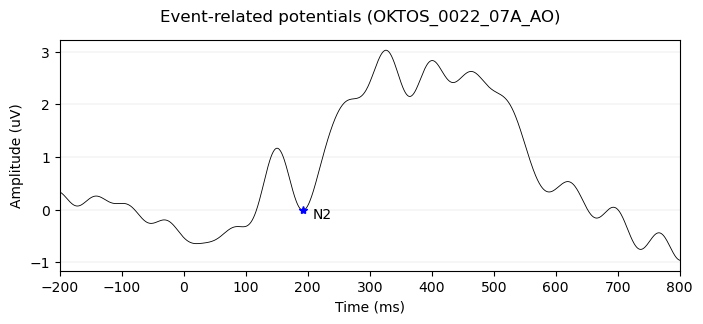

Changing time window parameters for OKTOS_0022_07A_AO
Changing N1 with new time window: [80, 120, -1]


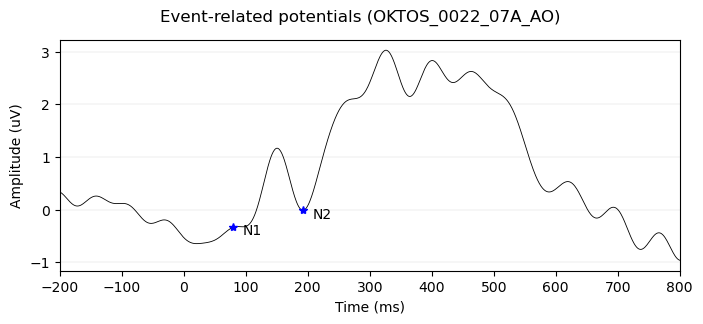

Changing time window parameters for OKTOS_0022_07A_AO
Changing P2 with new time window: [100, 200, 1]


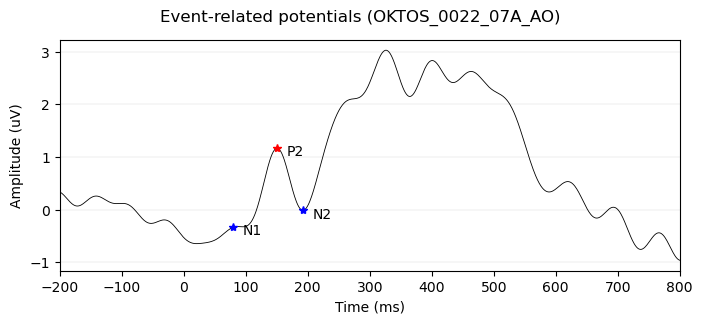

Changing time window parameters for OKTOS_0022_07A_AO
Changing P3 with new time window: [200, 400, 1]


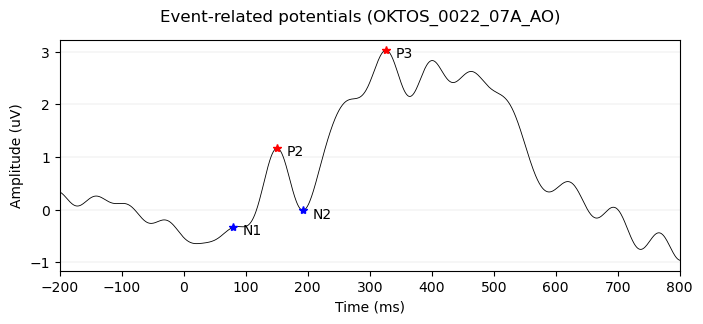

ERPs have been found and added to the dataframe for OKTOS_0022_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


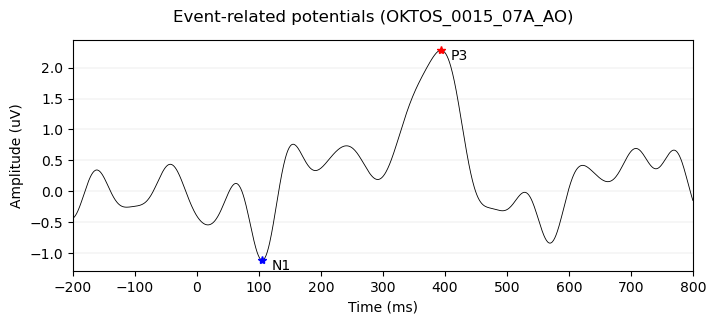

Changing time window parameters for OKTOS_0015_07A_AO
Changing P2 with new time window: [100, 300, 1]


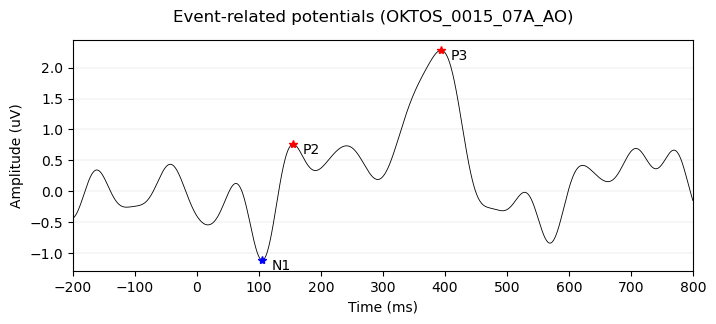

Changing time window parameters for OKTOS_0015_07A_AO
Changing N2 with new time window: [200, 350, -1]


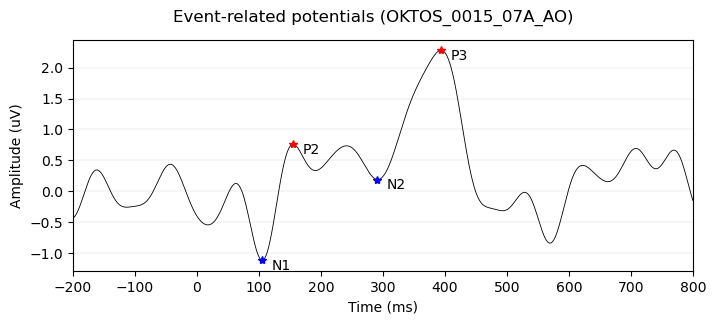

ERPs have been found and added to the dataframe for OKTOS_0015_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


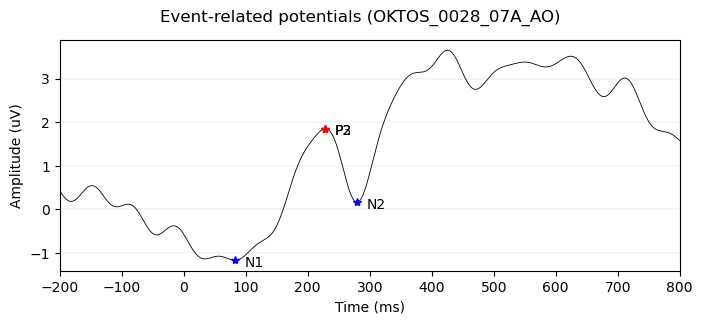

Changing time window parameters for OKTOS_0028_07A_AO
Changing P3 with new time window: [300, 500, 1]


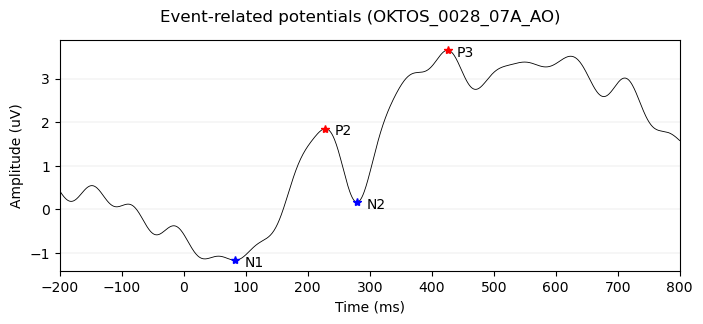

ERPs have been found and added to the dataframe for OKTOS_0028_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


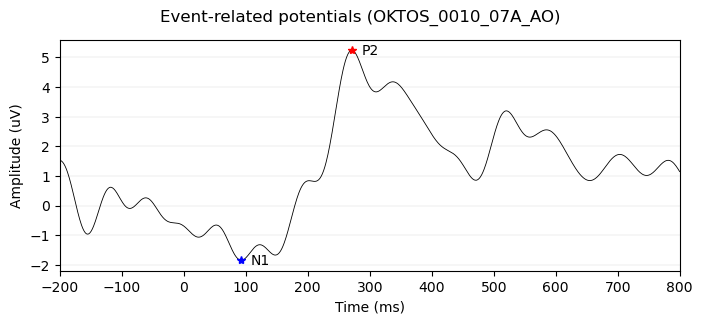

Changing time window parameters for OKTOS_0010_07A_AO
Changing N2 with new time window: [130, 200, -1]


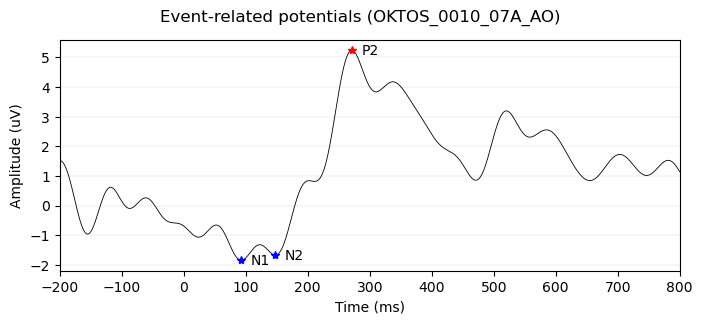

Changing time window parameters for OKTOS_0010_07A_AO
Changing P2 with new time window: [100, 150, 1]


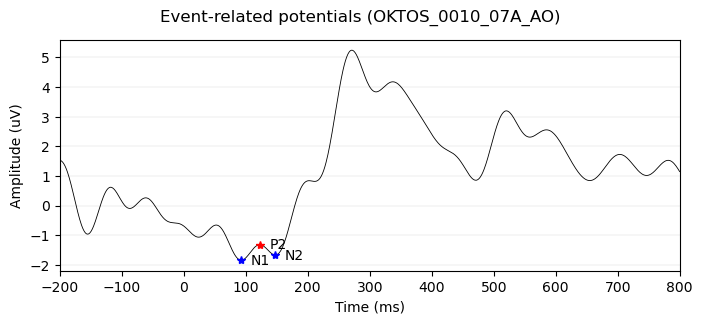

Changing time window parameters for OKTOS_0010_07A_AO
Changing P3 with new time window: [200, 400, 1]


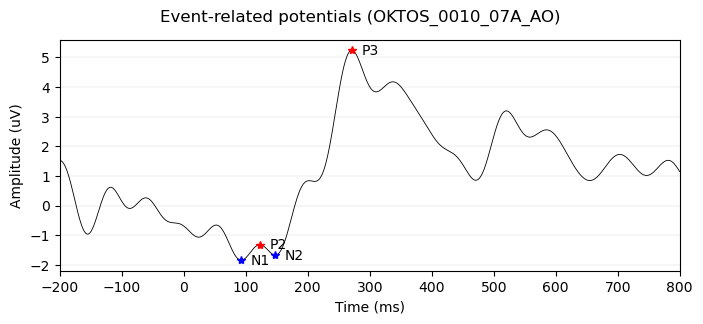

ERPs have been found and added to the dataframe for OKTOS_0010_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


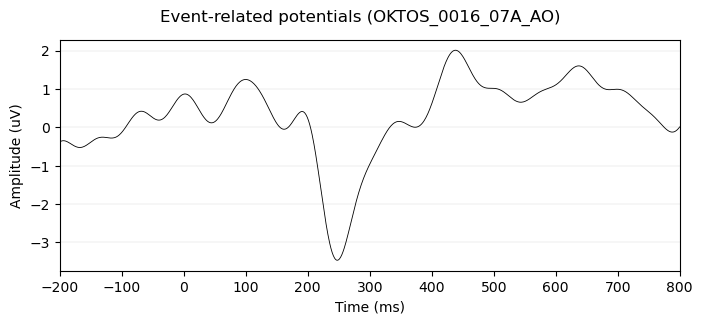

Changing time window parameters for OKTOS_0016_07A_AO
Changing N2 with new time window: [200, 300, -1]


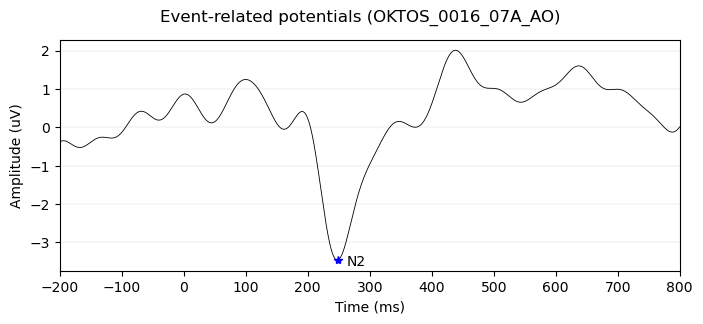

Changing time window parameters for OKTOS_0016_07A_AO
Changing P3 with new time window: [300, 500, 1]


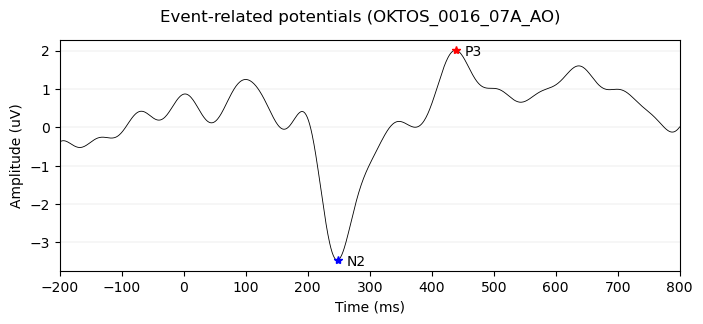

Changing time window parameters for OKTOS_0016_07A_AO
Changing P2 with new time window: [50, 150, 1]


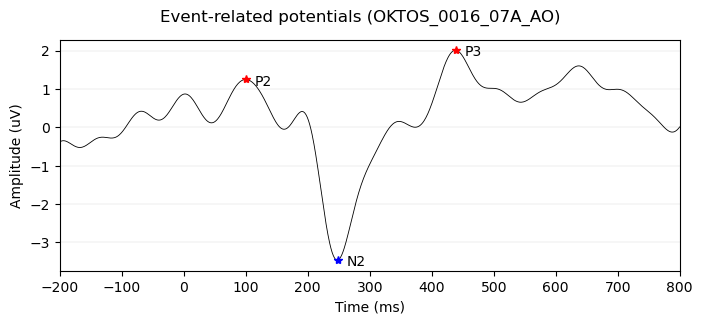

Changing time window parameters for OKTOS_0016_07A_AO
Changing N1 with new time window: [30, 100, -1]


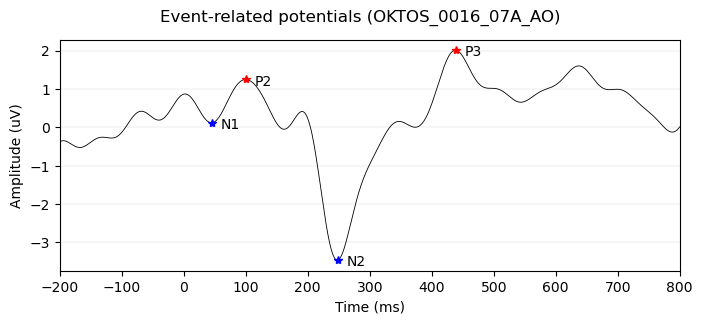

ERPs have been found and added to the dataframe for OKTOS_0016_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


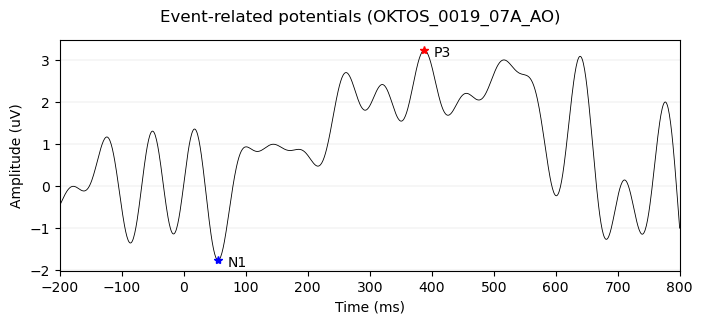

ERPs have been found and added to the dataframe for OKTOS_0019_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


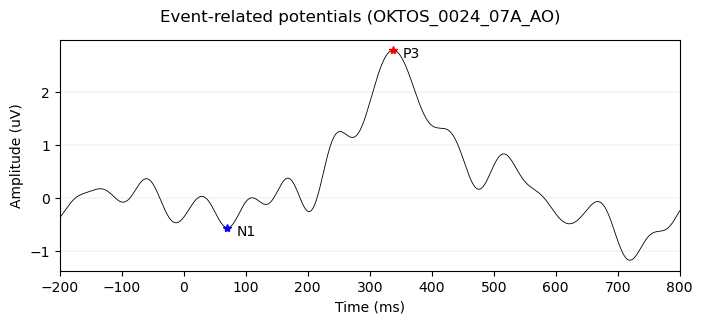

ERPs have been found and added to the dataframe for OKTOS_0024_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


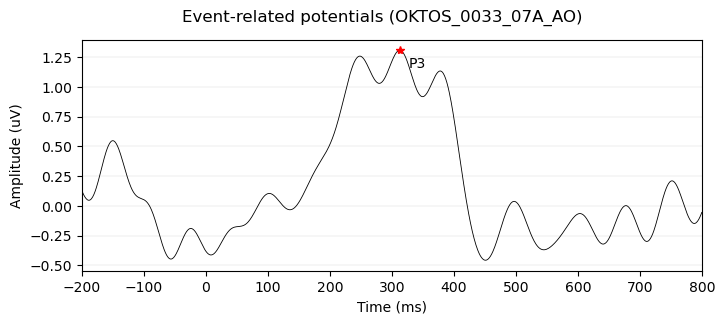

ERPs have been found and added to the dataframe for OKTOS_0033_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


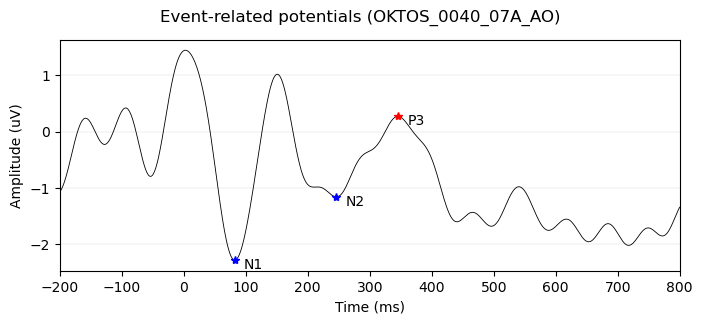

Changing time window parameters for OKTOS_0040_07A_AO
Changing P2 with new time window: [100, 200, 1]


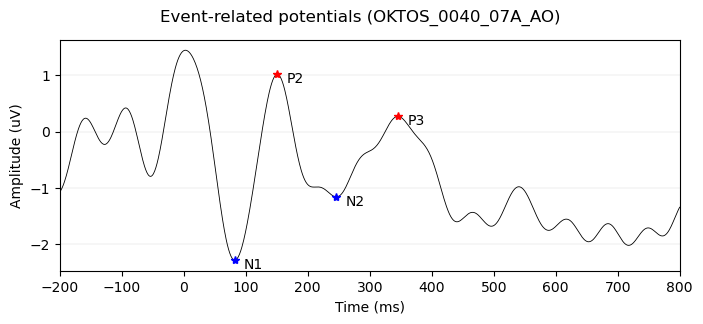

ERPs have been found and added to the dataframe for OKTOS_0040_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


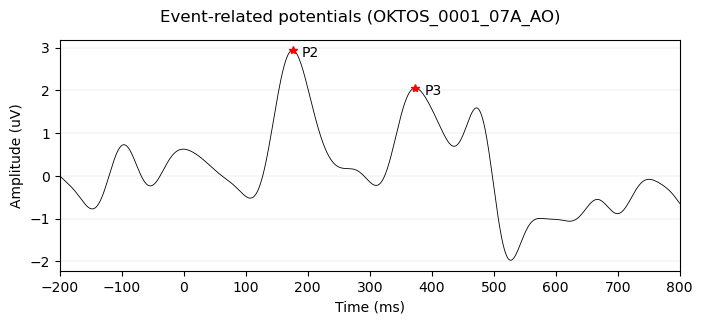

Changing time window parameters for OKTOS_0001_07A_AO
Changing N1 with new time window: [80, 120, -1]


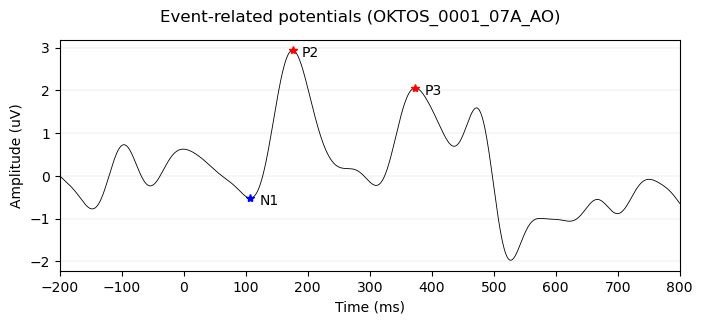

Changing time window parameters for OKTOS_0001_07A_AO
Changing N2 with new time window: [200, 400, -1]


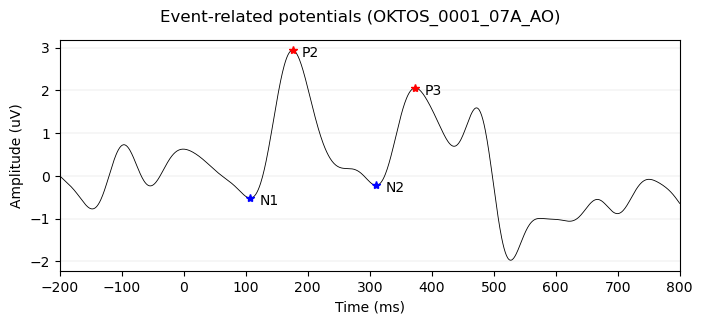

ERPs have been found and added to the dataframe for OKTOS_0001_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


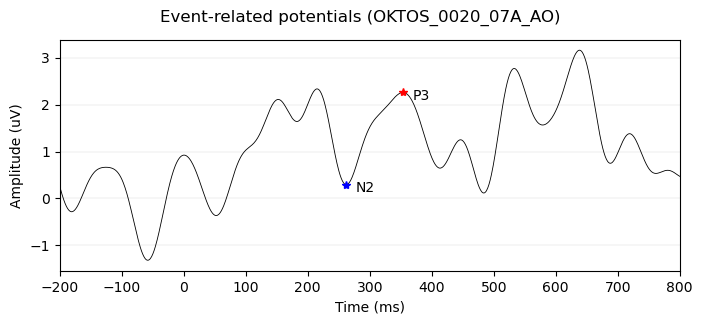

Changing time window parameters for OKTOS_0020_07A_AO
Changing N1 with new time window: [40, 100, -1]


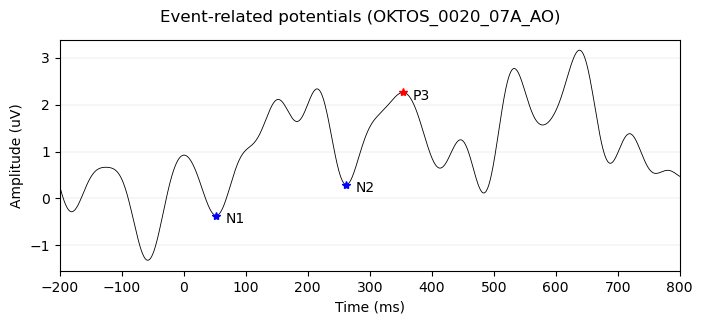

Changing time window parameters for OKTOS_0020_07A_AO
Changing P2 with new time window: [100, 250, 1]


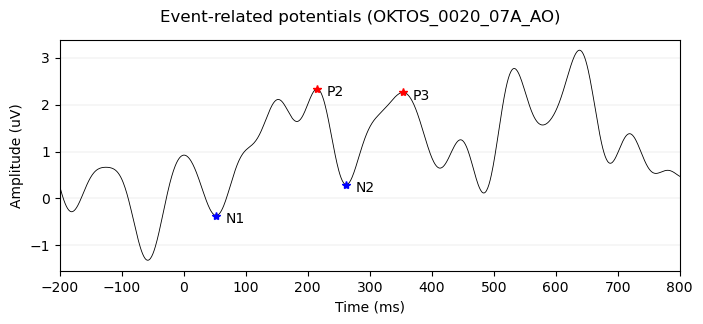

ERPs have been found and added to the dataframe for OKTOS_0020_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


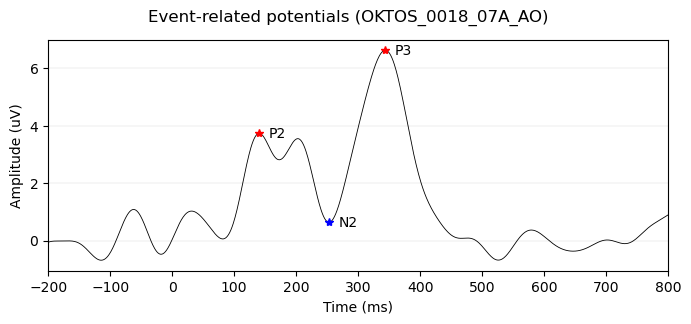

Changing time window parameters for OKTOS_0018_07A_AO
Changing N1 with new time window: [50, 100, -1]


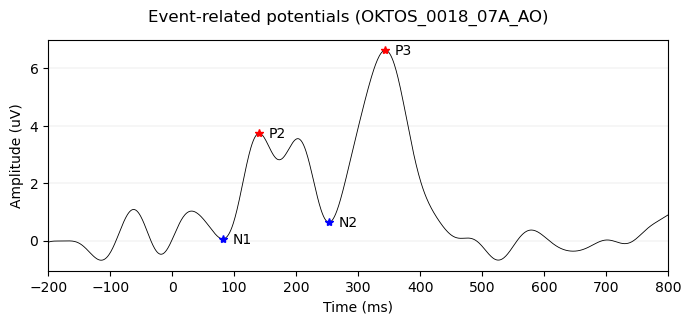

ERPs have been found and added to the dataframe for OKTOS_0018_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


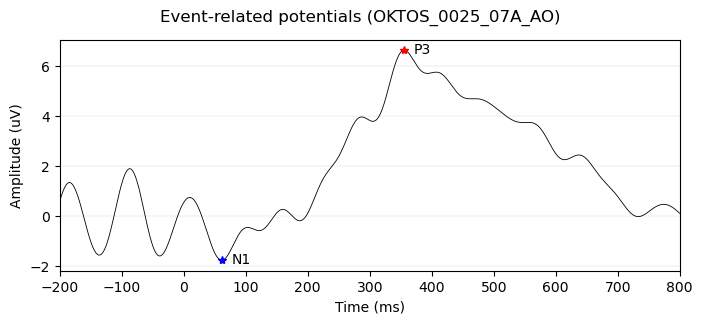

Changing time window parameters for OKTOS_0025_07A_AO
Changing P2 with new time window: [100, 200, 1]


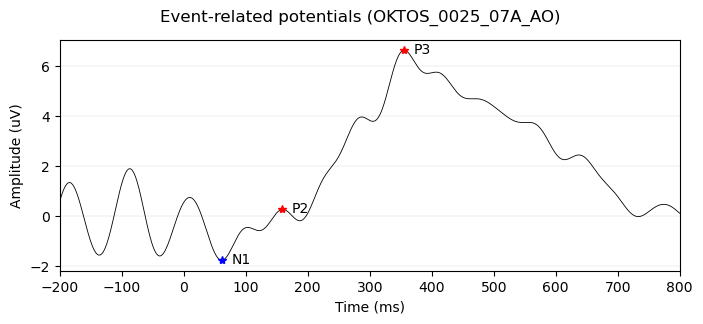

Changing time window parameters for OKTOS_0025_07A_AO
Changing N2 with new time window: [150, 220, -1]


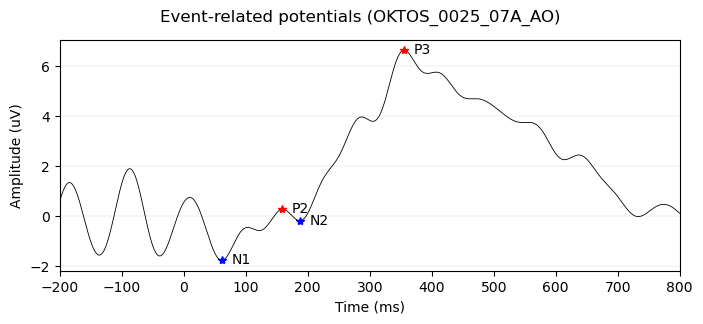

ERPs have been found and added to the dataframe for OKTOS_0025_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


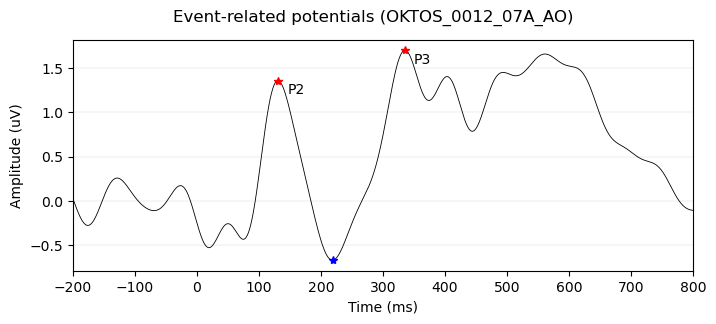

Changing time window parameters for OKTOS_0012_07A_AO
Changing N1 with new time window: [50, 100, -1]


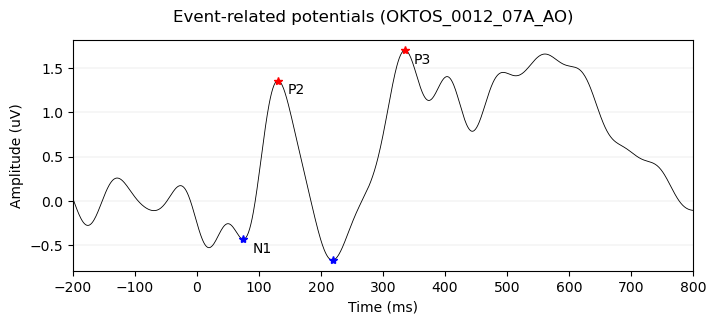

ERPs have been found and added to the dataframe for OKTOS_0012_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


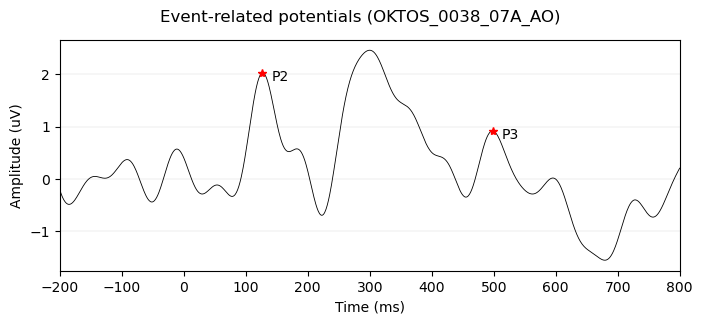

Changing time window parameters for OKTOS_0038_07A_AO
Changing N1 with new time window: [50, 120, -1]


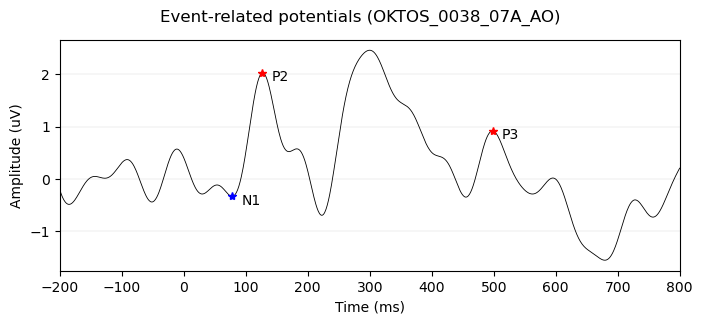

Changing time window parameters for OKTOS_0038_07A_AO
Changing N2 with new time window: [150, 250, -1]


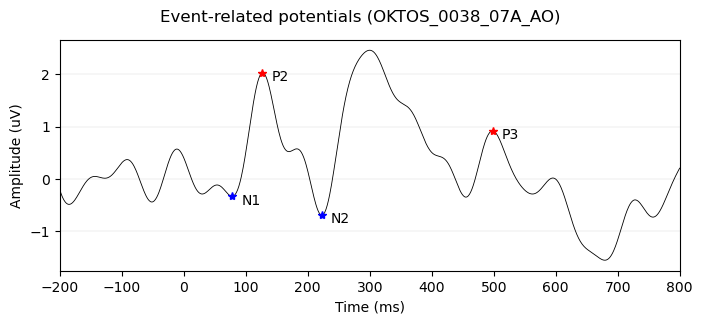

Changing time window parameters for OKTOS_0038_07A_AO
Changing P3 with new time window: [220, 400, 1]


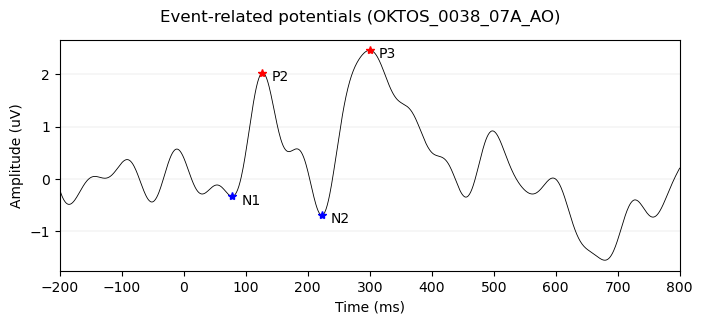

ERPs have been found and added to the dataframe for OKTOS_0038_07A_AO


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933


Adding relative amplitudes for N1-P2, P2-N2, N2-P3


,N1 latency,N2 latency,P2 latency,P3 latency,N1 amplitude,N2 amplitude,P2 amplitude,P3 amplitude,N1-P2 amplitude,P2-N2 amplitude,N2-P3 amplitude
OKTOS_0031_07A_AO,85.937500,168.945312,125.976562,389.648438,-2.398635,-2.462836,-1.225949,5.566867,1.172686,-1.236888,8.029704
OKTOS_0003_07A_AO,85.937500,219.726562,144.531250,423.828125,-1.558021,-0.391474,0.436416,4.134873,1.994437,-0.827890,4.526347
OKTOS_0006_07A_AO,137.695312,240.234375,185.546875,452.148438,-2.327533,-1.860034,0.772859,1.872475,3.100392,-2.632893,3.732510
OKTOS_0011_07A_AO,76.171875,167.968750,127.929688,363.281250,-1.848736,-1.164894,0.785367,3.667356,2.634103,-1.950261,4.832250
OKTOS_0029_07A_AO,93.750000,305.664062,144.531250,530.273438,-0.416145,-2.292230,1.856434,0.887047,2.272579,-4.148664,3.179277
OKTOS_0026_07A_AO,56.640625,239.257812,143.554688,355.468750,-0.459231,-0.118506,1.114920,1.651166,1.574152,-1.233426,1.769672
OKTOS_0023_07A_AO,76.171875,172.851562,130.859375,353.515625,-1.072097,-0.131289,0.315209,2.575550,1.387306,-0.446498,2.706839
OKTOS_0002_07A_AO,65.429688,245.117188,198.242188,371.093750,-0.798933,-0.663997,1.011626,2.272144,1.810559,-1.675623,2.936141
OKTOS_0007_07A_AO,100.585938,221.679688,141.601562,531.250000,-1.027221,-0.923528,1.337219,3.257044,2.364440,-2.260747,4.180572
OKTOS_0008_07A_AO,79.101562,232.421875,168.945312,499.023438,-0.055454,-3.843937,1.887579,1.562933,1.943033,-5.731516,5.406870


In [9]:

# Define these!
erp_wins = {'N1':[40, 170, -1],
            'N2':[180, 350, -1],
            'P2':[100, 260, 1],
            'P3':[270, 500, 1]}
channel_picks = ['Pz']
event_list = ['target after 1 standard','target after 3 standards','target after 5 standards',
            'target after 7 standards','target after 9 standards','target after 11 standards']

dir_inprogress = os.path.join(clean_folder,exp_folder)
export_dir = os.path.join(clean_folder,exp_folder)
file_dirs, subject_names = arrange.read_files(dir_inprogress,"_clean-epo.fif")

# Pre-defined variables
df_erps = pd.DataFrame()
evoked_signal = [None]*len(file_dirs)

for i in range(len(file_dirs)):
    erp_wins_temp = erp_wins
    # Read the clean data from the disk
    epochs = mne.read_epochs(fname='{}/{}_clean-epo.fif'.format(dir_inprogress,subject_names[i]),verbose=False)
    
    # Create an averaged evoked object from epochs for 
    evoked_signal[i] = epochs[event_list].average(picks=channel_picks)

    # Find all the peaks in the evoked signal
    minpeak_times, minpeak_mags, maxpeak_times, maxpeak_mags = erpan.find_all_peaks(evoked_signal[i], epochs,
                                                                              thresh=None, # thresh seems not to work
                                                                              subject_name=subject_names[i],
                                                                              verbose=False, plot=False)
    
    # Identify which peaks are which ERPs based on the pre-defined ERP time window dictionary
    erp_peaks, not_erp_peaks = erpan.identify_erps(evoked_signal[i],erp_wins_temp,minpeak_times,minpeak_mags,maxpeak_times,maxpeak_mags,
                                             subject_name=subject_names[i],verbose=False,plot=True,savefig=True,
                                             results_foldername=results_foldername)

    # After visual inspection, it's possible to define the time windows to look for the peak
    while input('Do you need to do any manual time window changes? (leave empty if "no")') != '':
        print('Changing time window parameters for {}'.format(subject_names[i]))
        new_time_win = [None,None,None]

        erp_tochange = input('What ERP time window you want to change (e.g., N1)?')
        new_time_win[0] = int(input('Enter MIN time of the window in interest for {} (e.g., 50)'.format(erp_tochange)))
        new_time_win[1] = int(input('Enter MAX time of the window in interest for {} (e.g., 100)'.format(erp_tochange)))
        new_time_win[2] = int(input('Enter whether to look for MIN (-1) or MAX (1) voltage for {}'.format(erp_tochange)))

        erp_wins_temp[erp_tochange] = new_time_win

        print('Changing',erp_tochange,'with new time window:',str(new_time_win))
        try:
            erp_peaks = erpan.find_minmax_erp(evoked_signal[i],erp_peaks,erp_tochange,new_time_win,subject_name=subject_names[i],
                                        verbose=False,plot=True,savefig=True,results_foldername=results_foldername)
        except:
            print('Something went wrong with manual ERP detection, try again.')

    df_erps_temp = erpan.erp_dict_to_df(erp_peaks,erp_wins_temp,subject_names[i])
    df_erps = pd.concat([df_erps, df_erps_temp])
    
    print('ERPs have been found and added to the dataframe for {}'.format(subject_names[i]))
    display(df_erps)

print('Adding relative amplitudes for N1-P2, P2-N2, N2-P3')
df_erps['N1-P2 amplitude'] = df_erps['P2 amplitude'] - df_erps['N1 amplitude']
df_erps['P2-N2 amplitude'] = df_erps['N2 amplitude'] - df_erps['P2 amplitude']
df_erps['N2-P3 amplitude'] = df_erps['P3 amplitude'] - df_erps['N2 amplitude']

display(df_erps)
# Add all the detected peaks to an Excel spreadsheet
arrange.create_results_folders(exp_folder=exp_folder,results_foldername=results_foldername)
df_erps.to_excel(r"{}/{}_{}_grandaverage_erps.xlsx".format(results_foldername,exp_condition,channel_picks))